In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)

os.environ['PATH'] = os.environ['XILINX_VITIS'] + '/bin:' + os.environ['PATH']

# May need to update path to match local installation
import sys
sys.path.append("/home/{}/Locked-in-Leptons/helpers/".format(os.environ['USER']))
import plotting
from helper import get_traintest


2025-05-12 13:18:43.840228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-12 13:18:43.851749: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-12 13:18:43.855227: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-12 13:18:43.864459: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-12 13:18:44.834643: W tensorflow/compiler/tf2

# Load the data

In [2]:
# parquet data files need to be in same directory
x_train, x_test, y_train, y_test = get_traintest()

In [3]:
y_train = to_categorical(y_train,2) 
y_test = to_categorical(y_test,2)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Load the model

In [4]:
from tensorflow.keras.models import load_model

model = load_model('model_1/KERAS_check_best_model.h5')
y_keras = model.predict(x_test)

2025-05-12 13:21:28.267970: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38148 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:27:00.0, compute capability: 8.0


816341/816341 [==============================] - 575s 703us/step


## Make hls4ml config & model

In [5]:
import hls4ml
import plotting

config = hls4ml.utils.config_from_keras_model(model, granularity='name', backend='Vitis')
print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 17]], output shape: [None, 17]
Layer name: fc1, layer type: Dense, input shapes: [[None, 17]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 2]
Layer name: activation, layer type: Softmax, input shapes: [[None, 2]], output shape: [None, 2]
-----------------------------------
Model
  Precision:         fixed<16,6>
  ReuseFactor:       1
  Strategy:          Laten

/home/frodriguez/.conda/envs/hls4ml-tutorial/lib/python3.12/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


# Profiling

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 17]], output shape: [None, 17]
Layer name: fc1, layer type: Dense, input shapes: [[None, 17]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 2]
Layer name: activation, layer type: Softmax, input shapes: [[None, 2]], output shape: [None, 2]
Creating HLS model
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 17

/home/frodriguez/.conda/envs/hls4ml-tutorial/lib/python3.12/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done
   fc1
   relu1
   fc2
   relu2
   fc3
   relu3
   output
   activation


(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>)

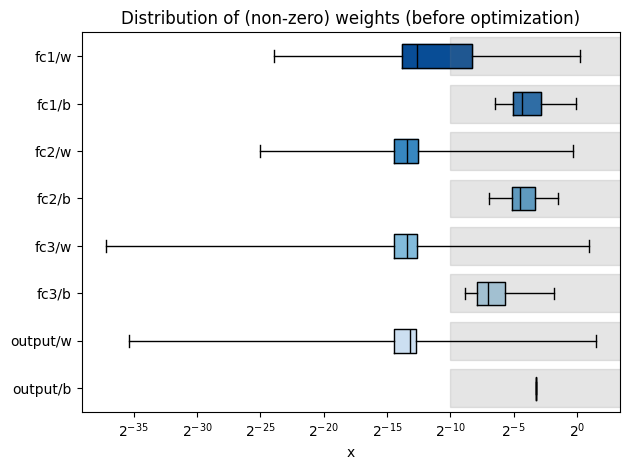

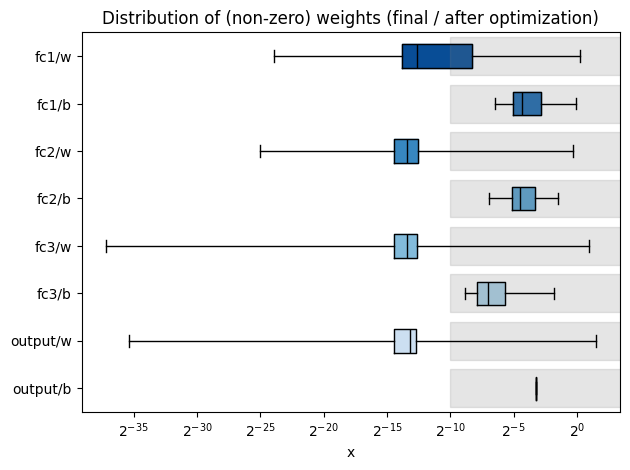

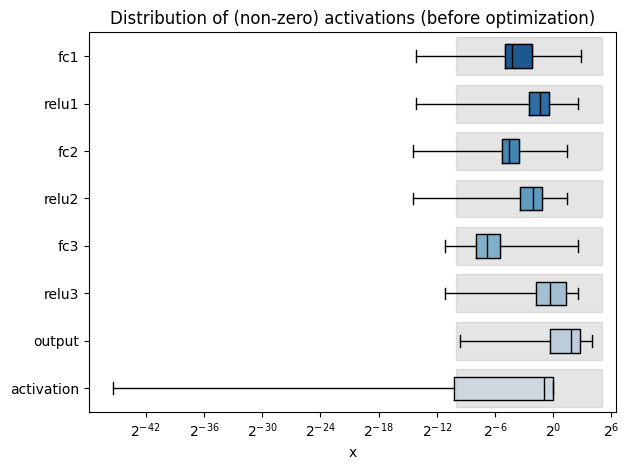

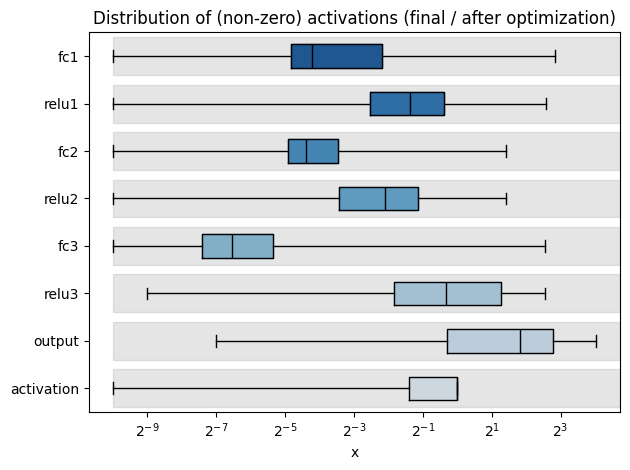

In [6]:
%matplotlib inline
from hls4ml.model.profiling import numerical, get_ymodel_keras

for layer in config['LayerName'].keys():
    config['LayerName'][layer]['Trace'] = True
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_1/hls4ml_prj_4', part='xcu250-figd2104-2L-e'
)
numerical(model=model, hls_model=hls_model, X=x_test[:1000])

# Customize

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 17]], output shape: [None, 17]
Layer name: fc1, layer type: Dense, input shapes: [[None, 17]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 2]
Layer name: activation, layer type: Softmax, input shapes: [[None, 2]], output shape: [None, 2]
Creating HLS model
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 17

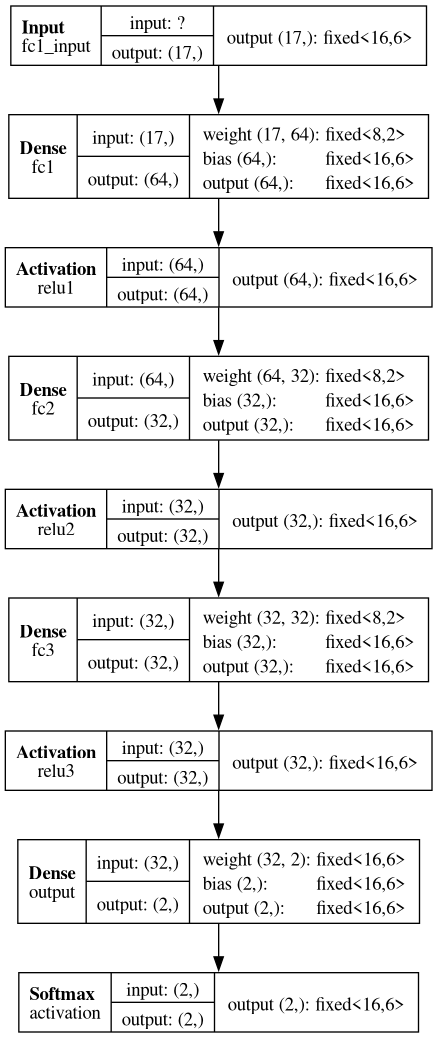

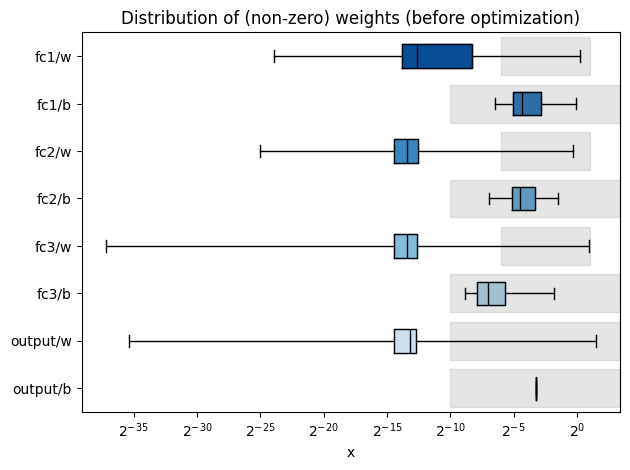

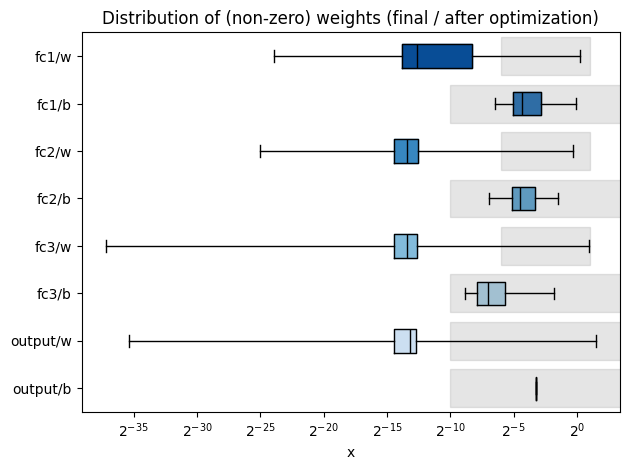

In [7]:
config['LayerName']['fc1']['Precision']['weight'] = 'ap_fixed<8,2>'
config['LayerName']['fc2']['Precision']['weight'] = 'ap_fixed<8,2>'
config['LayerName']['fc3']['Precision']['weight'] = 'ap_fixed<8,2>'


hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_1/hls4ml_prj_4', part='xcu250-figd2104-2L-e'
)
numerical(model=model, hls_model=hls_model)
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

# Trace

In [8]:
for layer in config['LayerName'].keys():
    config['LayerName'][layer]['Trace'] = True
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, backend='Vitis', output_dir='model_1/hls4ml_prj_4', part='xcu250-figd2104-2L-e'
)

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 17]], output shape: [None, 17]
Layer name: fc1, layer type: Dense, input shapes: [[None, 17]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 2]
Layer name: activation, layer type: Softmax, input shapes: [[None, 2]], output shape: [None, 2]
Creating HLS model


# Compile, trace, predict

In [9]:
hls_model.compile()
hls4ml_pred, hls4ml_trace = hls_model.trace(x_test[:1000])
keras_trace = get_ymodel_keras(model, x_test[:1000])
y_hls = hls_model.predict(x_test)

Writing HLS project


/home/frodriguez/.conda/envs/hls4ml-tutorial/lib/python3.12/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done
Recompiling myproject with tracing
Writing HLS project
Done
32/32 [==============================] - 0s 816us/step
Done taking outputs for Keras model.


Keras  Accuracy: 0.8929084552838806
hls4ml Accuracy: 0.8921458672021052
NoMET
MET
NoMET
MET


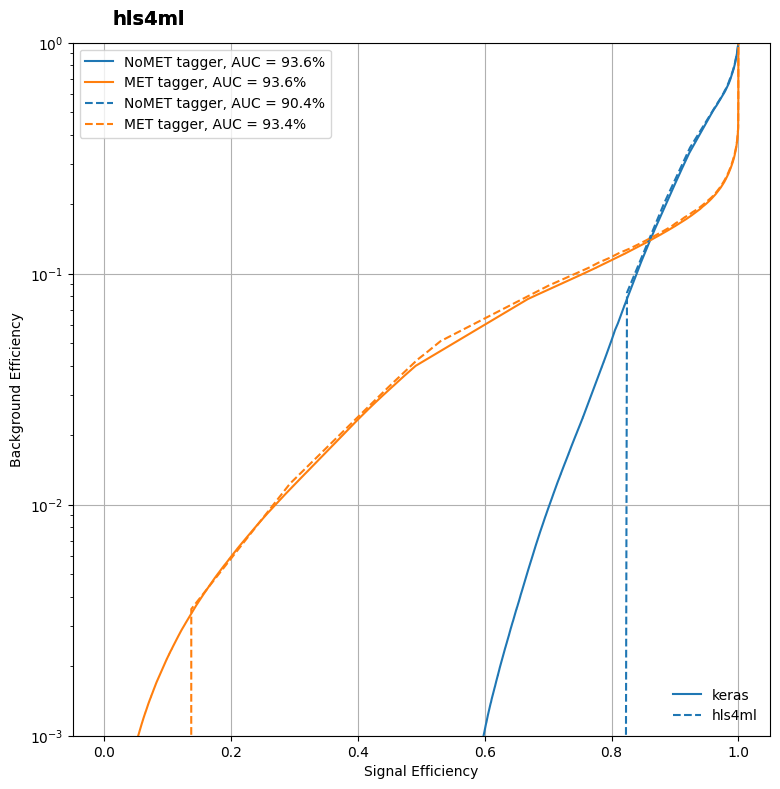

In [10]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, ["NoMET", "MET"])
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls, ["NoMET", "MET"], linestyle='--')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['keras', 'hls4ml'], loc='lower right', frameon=False)
ax.add_artist(leg)

plt.savefig("plots/ROC_thirdlayer.png")


In [11]:
hls_model.build(csim=False)


****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2023.1 (64-bit)
  **** SW Build 3854077 on May  4 2023
  **** IP Build 3864474 on Sun May  7 20:36:21 MDT 2023
  **** SharedData Build 3865790 on Sun May 07 13:33:03 MDT 2023
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
    ** Copyright 2022-2023 Advanced Micro Devices, Inc. All Rights Reserved.

source /opt/metis/el8/contrib/amdtools/xilinx-2023.1/Vitis_HLS/2023.1/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/opt/metis/el8/contrib/amdtools/xilinx-2023.1/Vitis_HLS/2023.1/bin/unwrapped/lnx64.o/vitis_hls'
INFO: [HLS 200-10] For user 'frodriguez' on host 'vm01.head.cm.local' (Linux_x86_64 version 4.18.0-372.9.1.el8.x86_64) on Mon May 12 14:14:05 CDT 2025
INFO: [HLS 200-10] On os "Red Hat Enterprise Linux release 8.6 (Ootpa)"
INFO: [HLS 200-10] In directory '/nfs/ihfs/home_metis/frodriguez/Locked-in-Leptons/DNN/model_1/hls4ml_prj_4'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Run

INFO: [HLS 200-111] Finished Standard Transforms: CPU user time: 0.28 seconds. CPU system time: 0.01 seconds. Elapsed time: 0.29 seconds; current allocated memory: 2.338 GB.
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [HLS 200-111] Finished Checking Synthesizability: CPU user time: 0.18 seconds. CPU system time: 0 seconds. Elapsed time: 0.19 seconds; current allocated memory: 2.338 GB.
INFO: [XFORM 203-11] Balancing expressions in function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>' (firmware/nnet_utils/nnet_dense_latency.h:33:21)...399 expression(s) balanced.
INFO: [XFORM 203-11] Balancing expressions in function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>' (firmware/nnet_utils/nnet_dense_latency.h:33:21)...1045 expression(s) balanced.
INFO: [XFORM 203-11] Balancing expressions in function 'nnet::dense_latency<a

INFO: [SCHED 204-61] Pipelining function 'dense_latency<ap_fixed<16, 6, 5, 3, 0>, ap_fixed<16, 6, 5, 3, 0>, config8>'.
INFO: [HLS 200-1470] Pipelining result : Target II = NA, Final II = 1, Depth = 2, function 'dense_latency<ap_fixed<16, 6, 5, 3, 0>, ap_fixed<16, 6, 5, 3, 0>, config8>'
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111] Finished Scheduling: CPU user time: 2.33 seconds. CPU system time: 0 seconds. Elapsed time: 2.36 seconds; current allocated memory: 2.500 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Starting global binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111] Finished Binding: CPU user time: 0.17 seconds. CPU system time: 0.01 seconds. Elapsed time: 0.2 seconds; current allocated memory: 2.500 GB.
INFO: [HLS 200-10] -------------

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_ap_fixed_16_6_5_3_0_ap_fixed_16_6_5_3_0_relu_config7_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_ap_fixed_16_6_5_3_0_ap_fixed_16_6_5_3_0_relu_config7_s'.
INFO: [HLS 200-111] Finished Creating RTL model: CPU user time: 4.55 seconds. CPU system time: 0.06 seconds. Elapsed time: 4.7 seconds; current allocated memory: 2.609 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_latency_ap_fixed_16_6_5_3_0_ap_fixed_16_6_5_3_0_config8_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Generating core module 'mul_16s_5s_21_1_0': 1 instance(s).
INFO: [RTGEN 206-100] Generating core module 'mul_16s_6s_22_1_1': 1 

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '4.370',
  'BestLatency': '10',
  'WorstLatency': '10',
  'IntervalMin': '1',
  'IntervalMax': '1',
  'BRAM_18K': '4',
  'DSP': '52',
  'FF': '6550',
  'LUT': '44739',
  'URAM': '0',
  'AvailableBRAM_18K': '5376',
  'AvailableDSP': '12288',
  'AvailableFF': '3456000',
  'AvailableLUT': '1728000',
  'AvailableURAM': '1280'}}

In [12]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj_3')

Found 1 solution(s) in model_1/hls4ml_prj_3/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vitis HLS Report for 'myproject'
* Date:           Fri May  9 14:49:45 2025

* Version:        2023.1 (Build 3854077 on May  4 2023)
* Project:        myproject_prj
* Solution:       solution1 (Vivado IP Flow Target)
* Product family: virtexuplus
* Target device:  xcu250-figd2104-2L-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  |  5.00 ns|  4.371 ns|     0.62 ns|
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+-----+-----+---------+
    |  Latency (cycles) |   Latency (absolute)  |  Interval | Pipeline|
    |   min   |   max   |    min    |    max    | min | max |   Type  |
    +---------+---------

In [13]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj_4')

Found 1 solution(s) in model_1/hls4ml_prj_4/myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vitis HLS Report for 'myproject'
* Date:           Mon May 12 14:15:49 2025

* Version:        2023.1 (Build 3854077 on May  4 2023)
* Project:        myproject_prj
* Solution:       solution1 (Vivado IP Flow Target)
* Product family: virtexuplus
* Target device:  xcu250-figd2104-2L-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  |  5.00 ns|  4.370 ns|     0.62 ns|
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+-----+-----+---------+
    |  Latency (cycles) |   Latency (absolute)  |  Interval | Pipeline|
    |   min   |   max   |    min    |    max    | min | max |   Type  |
    +---------+---------